In this section the data is scraped from the Wikipedia page: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M. This is used to create a table that stores the postal code, borough, and neighboors.

In [9]:
import numpy as np
import pandas as pd

import json
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors

from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
from pandas.io.json import json_normalize
import folium

In [11]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
hmtl_data = requests.get(url).text

In [12]:
soup = BeautifulSoup(hmtl_data, "html5lib")

In [37]:
table_contents=[]
t_n = pd.DataFrame(columns=['PostalCode', 'Borough', 'Neighborhoods']
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

print(table_contents)
t_n=pd.DataFrame(table_contents)
t_n['Borough']=t_n['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                            'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})


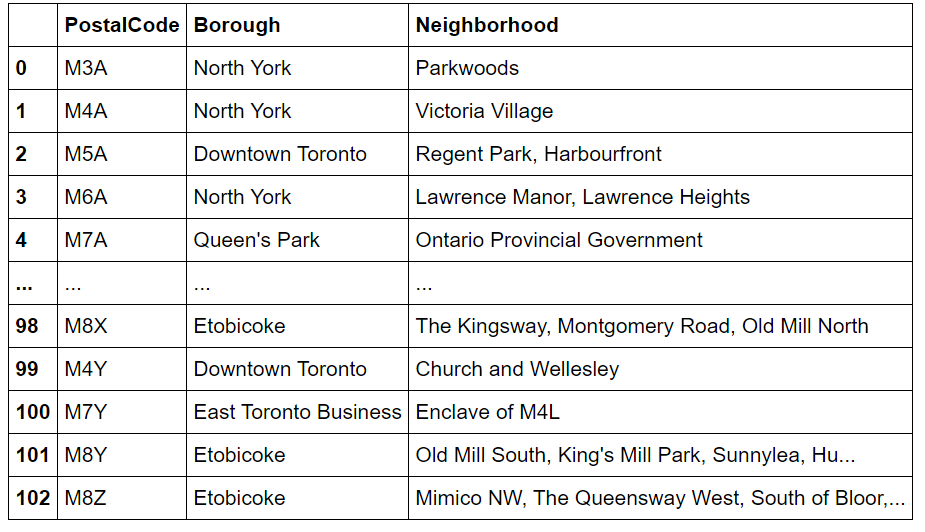

In [15]:
t_n


This section grabs the Latitude and Longitude from the Geospatial_Coordinates.csv and stores it in a DataFrame. From there it merges the new DataFrame and the one from the previous section.

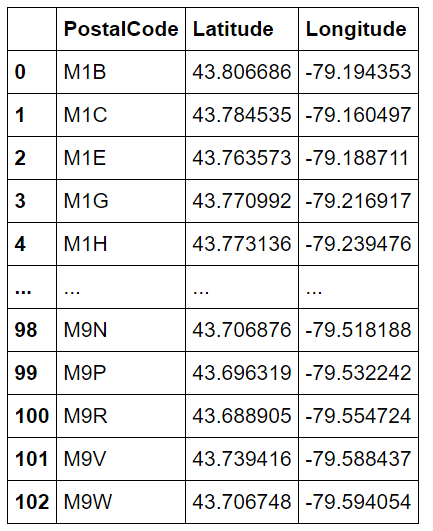

In [16]:
la_lng = pd.read_csv("Geospatial_Coordinates.csv")
names = ['PostalCode', 'Latitude', 'Longitude']
la_lng.columns = names
la_lng


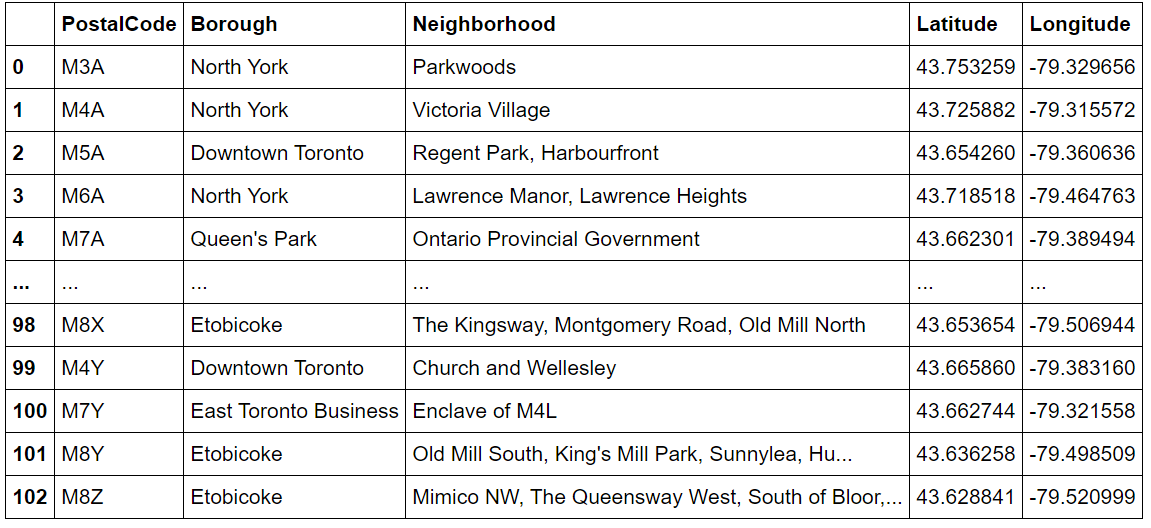

In [17]:
t_neghborhood = pd.merge(t_n, la_lng, on="PostalCode")
t_neghborhood


Clustering the Boroughs<br>
The Boroughs are grouped together and averaging their Latitude and Longitude.

In [18]:
t_neghborhood = t_neghborhood.drop(['PostalCode', 'Neighborhood'], axis=1)
Borough = t_neghborhood.groupby('Borough').mean().reset_index()

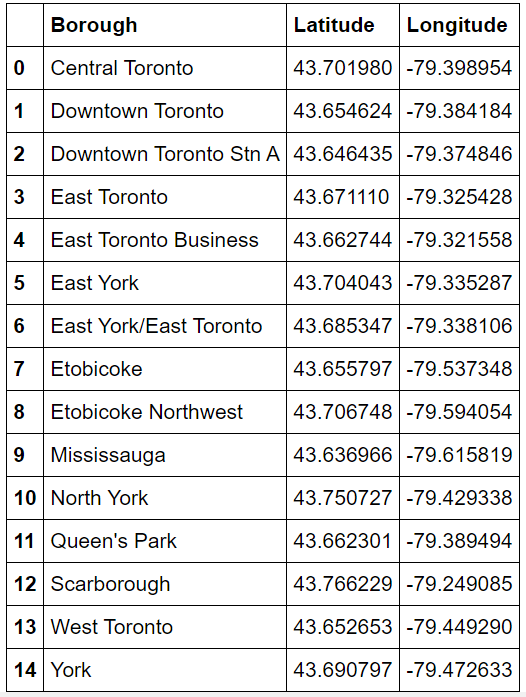

In [20]:
Borough


Setting the information used for getting the data from FourSquare.

In [21]:
CLIENT_ID = '' 
CLIENT_SECRET = ''
VERSION = '20180605' # Foursquare API version
LIMIT = 100 
radius = 500

Defining a function to grab the Venues, their locations, category, and place them into a DataFrame.

In [22]:

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


'\ndef getNearbyVenues(names, latitudes, longitudes, radius=500):\n    \n    venues_list=[]\n    for name, lat, lng in zip(names, latitudes, longitudes):\n            \n        # create the API request URL\n        url = \'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}\'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)\n            \n        # make the GET request\n        results = requests.get(url).json()["response"][\'groups\'][0][\'items\']\n        \n        # return only relevant information for each nearby venue\n        venues_list.append([(\n            name, \n            lat, \n            lng, \n            v[\'venue\'][\'name\'], \n            v[\'venue\'][\'location\'][\'lat\'], \n            v[\'venue\'][\'location\'][\'lng\'],  \n            v[\'venue\'][\'categories\'][0][\'name\']) for v in results])\n\n    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_


Getting the data for the Borough of Toronto.

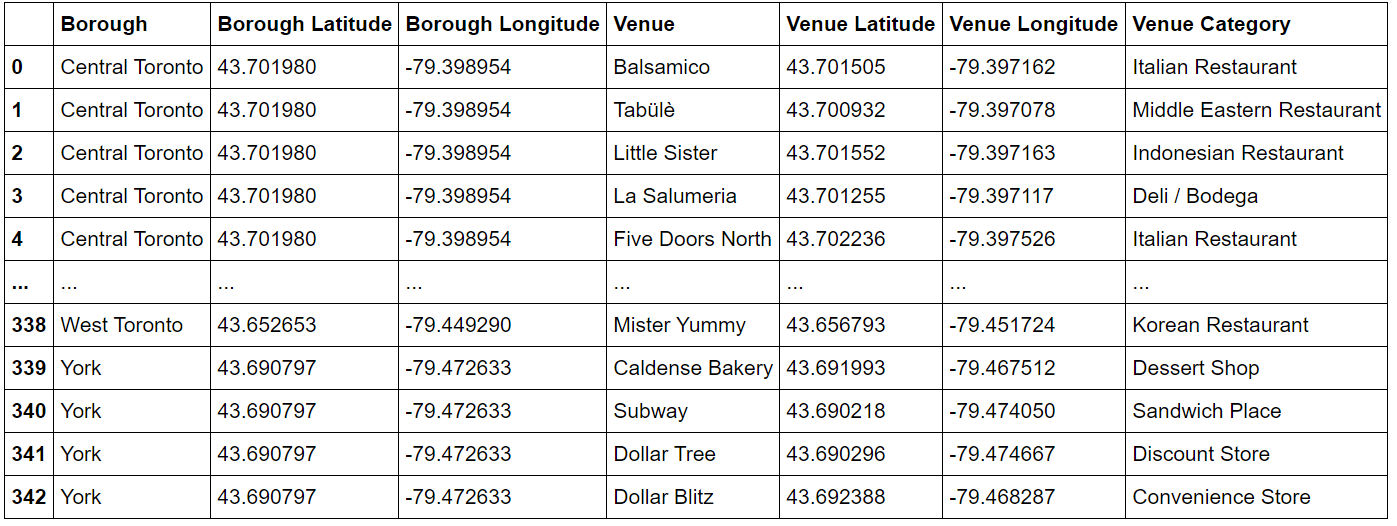

In [24]:
T_data = getNearbyVenues(names=Borough['Borough'], latitudes=Borough['Latitude'], longitudes=Borough['Longitude'])
T_data



Counting the Venues per Borough.

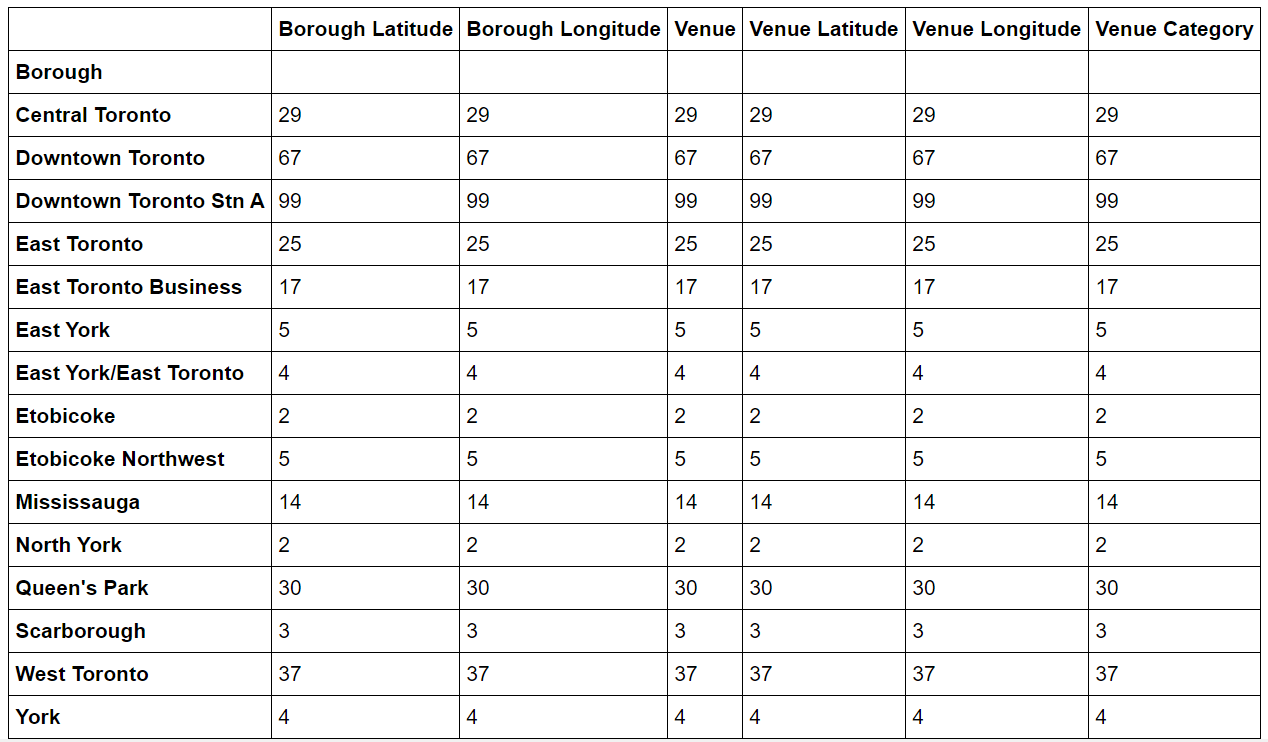

In [25]:
T_data.groupby('Borough').count()


Checking the amount of different Venue Category.

In [28]:
print('There are {} uniques categories.'.format(len(T_data['Venue Category'].unique())))


There are 137 uniques categories


Creating a onehot encoder for all the unique categories and creating a DataFrame.

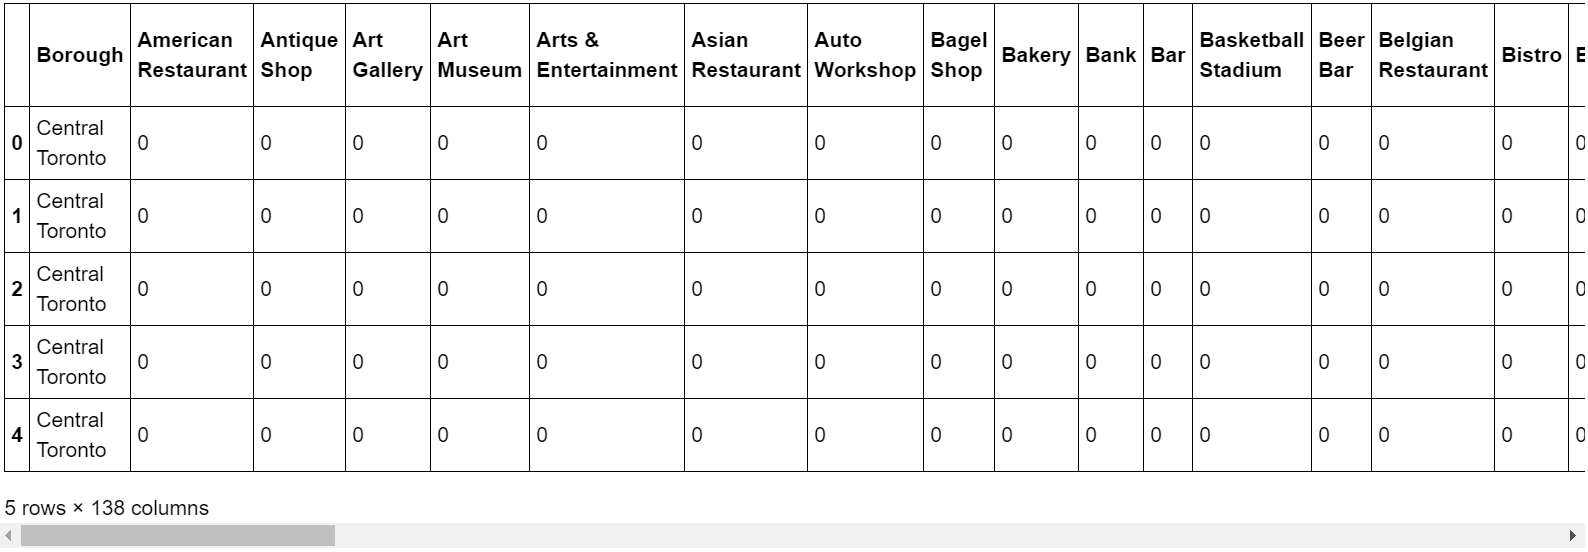

In [29]:
Borough_onehot = pd.get_dummies(T_data[['Venue Category']], prefix="", prefix_sep="")
Borough_onehot['Borough'] = T_data['Borough']
fixed_columns = [Borough_onehot.columns[-1]] + list(Borough_onehot.columns[:-1])
Borough_onehot = Borough_onehot[fixed_columns]
Borough_onehot.head()


Grouping the hot encoder by Borough.

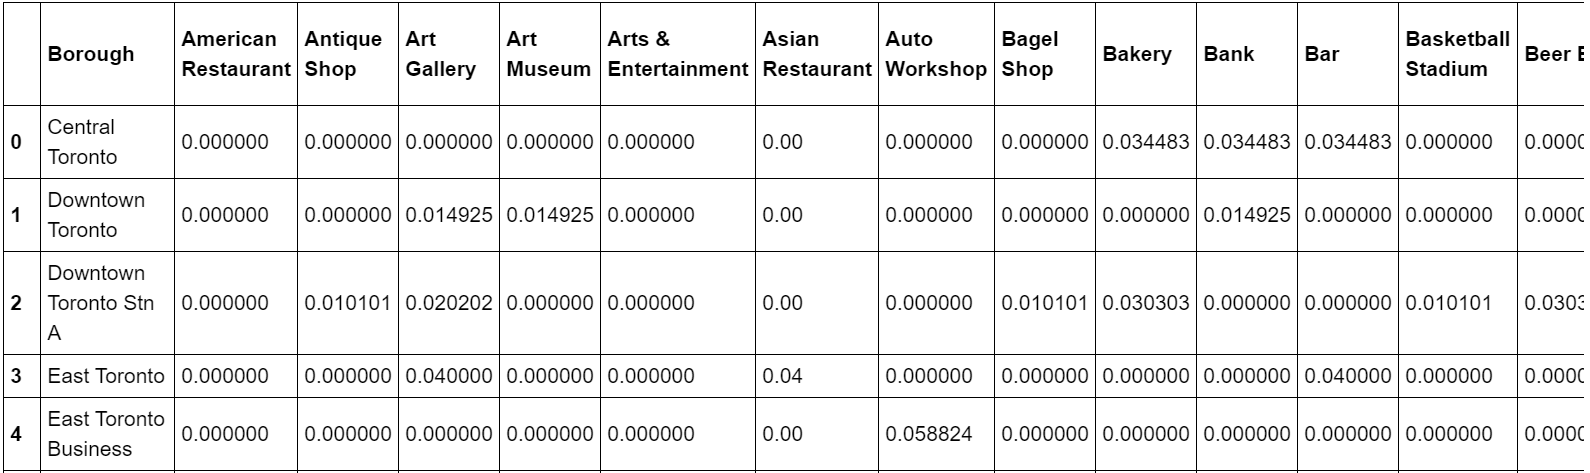

In [31]:
Borough_g = Borough_onehot.groupby('Borough').mean().reset_index()
Borough_g.head()



Creating a function that returns a index of the most common Venue Category.

In [32]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Creating a DataFrame with the most common Venue Category.

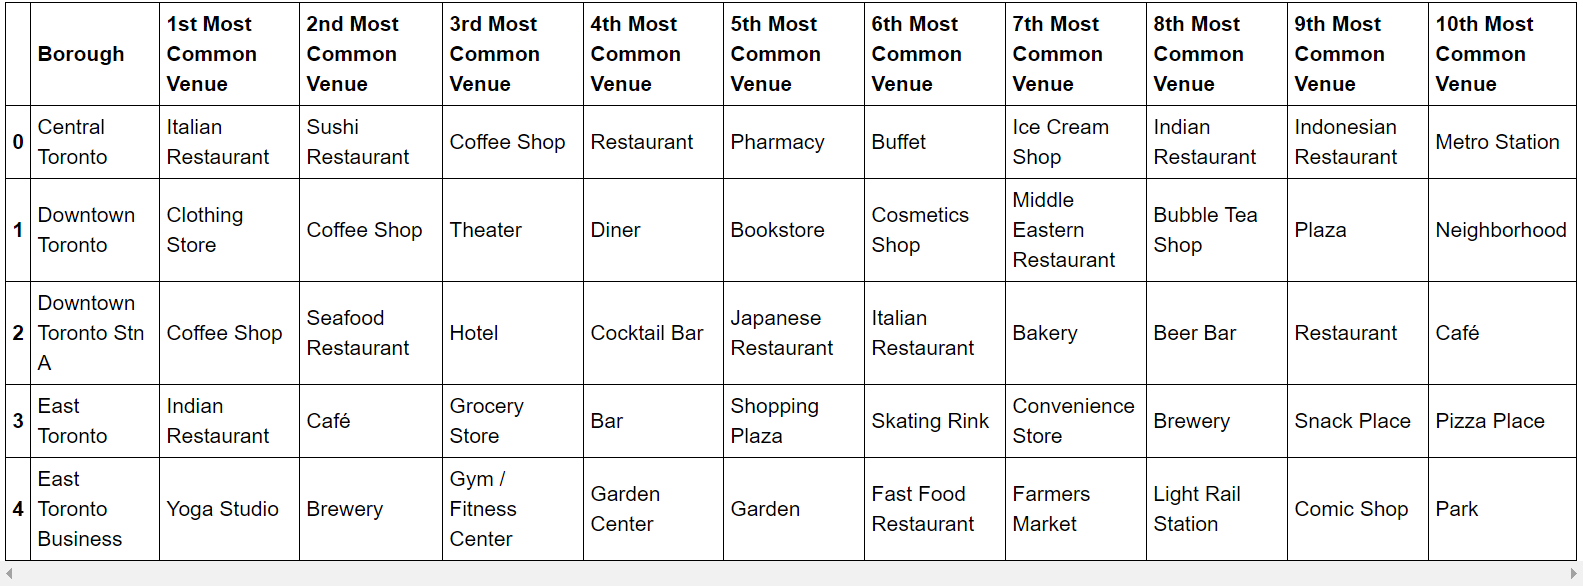

In [33]:
num_ten = 10
indicators = ['st', 'nd', 'rd']

columns = ['Borough']
for ind in np.arange(num_ten):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

Borough_venues_sorted = pd.DataFrame(columns=columns)
Borough_venues_sorted['Borough'] = Borough_g['Borough']

for ind in np.arange(Borough_g.shape[0]):
    Borough_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Borough_g.iloc[ind, :], num_ten)

Borough_venues_sorted.head()


Creating the Clustering using Kmeans. The model will run 15 times using the hot encoder data.

In [34]:
B_data = Borough_g.drop('Borough', axis=1)
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=15, random_state=0).fit(B_data)


Creating a new DataFrame with the Borough, Latitude, Lonitude, Cluster Value, and the ten most Common Venue Category.

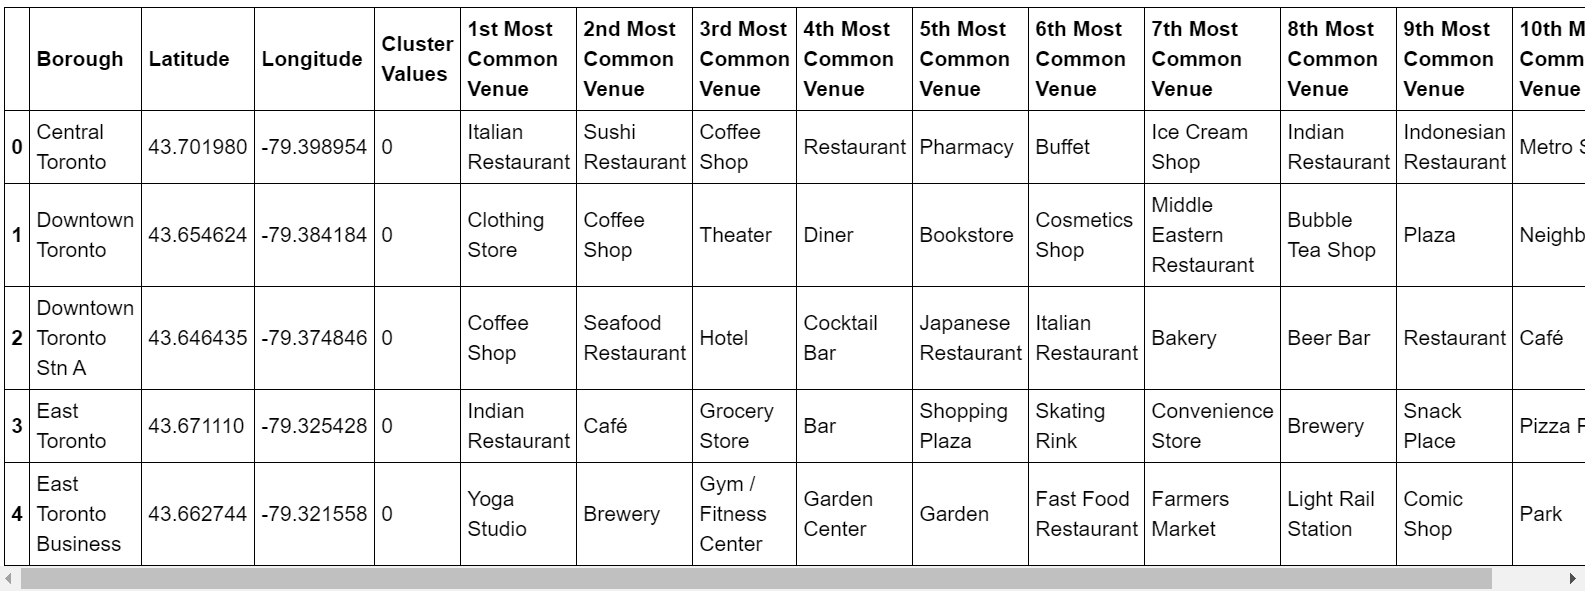

In [35]:
Borough_venues_sorted.insert(0, 'Cluster Values', kmeans.labels_)
Final_data = pd.merge(Borough, Borough_venues_sorted)
Final_data.head()


Creating a map with the clustering.

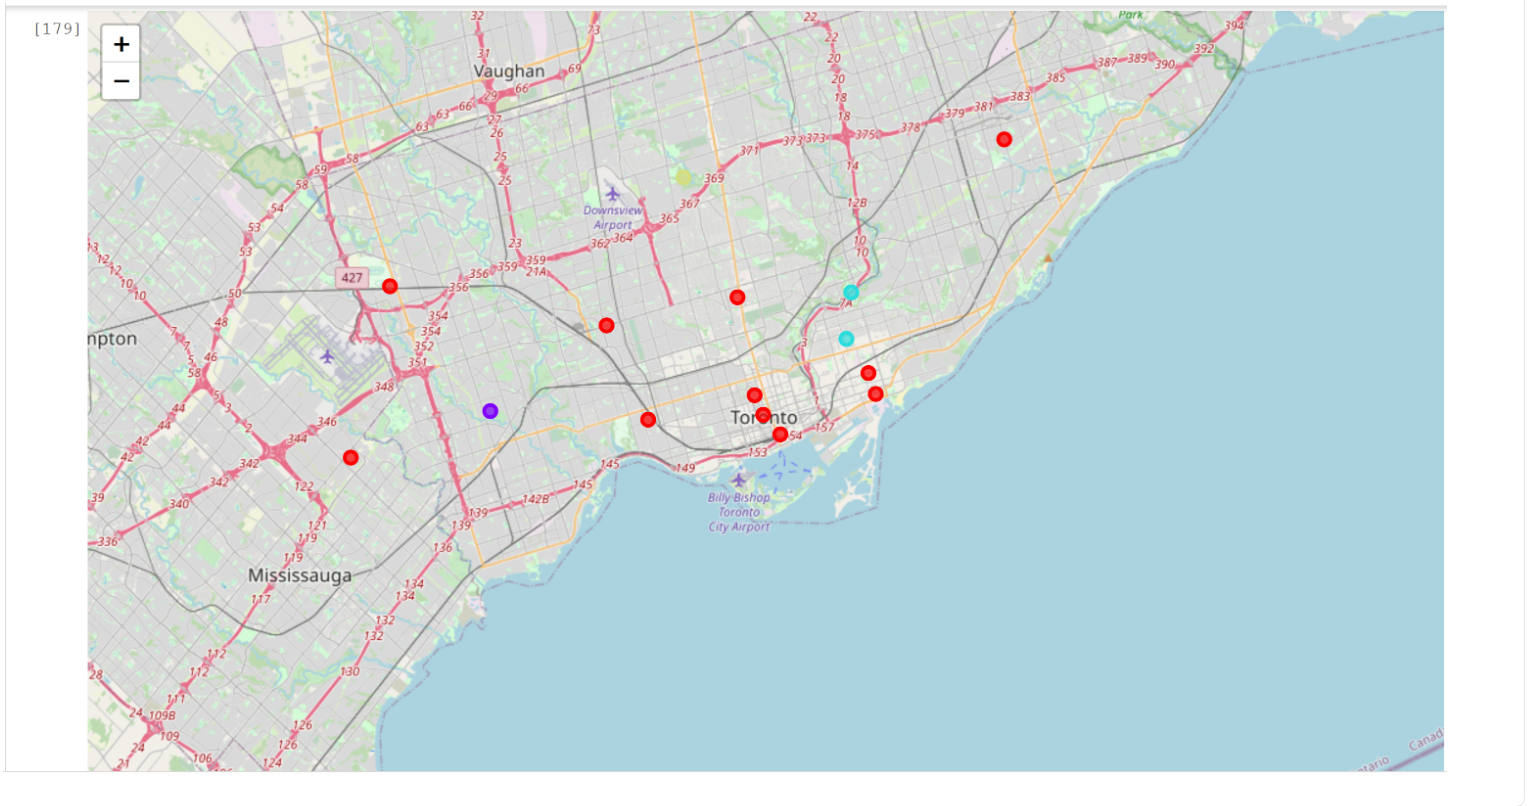

In [36]:

map_clusters = folium.Map(location=[43.6532, -79.3832], zoom_start=11)

x = np.arange(4)
ys = [i + x + (i*x)**2 for i in range(4)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(Final_data['Latitude'], Final_data['Longitude'], Final_data['Borough'], Final_data['Cluster Values']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters
